# Проект: Предсказание стоимости жилья в Калифорнии

__Цель проекта__: разработка модели линейной регрессии для предсказания медианной стоимости дома в жилом массиве Калифорнии

__Описание данных__: данные о жилье в Калифорнии в 1990 году. Каждая строка содержит агрегированную статистику о жилом массиве. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

__Используемые метрики__: RMSE, MAE, R2.

## Подготовка данных

In [ ]:
# импортируем необходимые библиотеки
import numpy as np
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder,\
    VectorAssembler, StandardScaler, Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# константы
RANDOM_SEED = 2022

### Загрузка данных

Инициализируем локальную Spark-сессию.

In [3]:
spark = SparkSession \
    .builder \
    .master("local")\
    .appName("ML California housing") \
    .getOrCreate()                               

Загрузим данные для работы. Выведем общее количество строк, первые 5 строк и схему таблицы.

In [ ]:
df_housing = spark.read.load('/datasets/data.csv',
    format="csv", sep=",", inferSchema=True, header="true")

In [5]:
df_housing.count()

20640

In [6]:
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [7]:
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Создадим списки с названиями столбцов в зависимости от типов данных.

In [8]:
categorical_cols = ['ocean_proximity']
numerical_cols = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', \
                  'total_bedrooms', 'population', 'households', 'median_income']
target = 'median_house_value'

Данные соответствуют описанию. В датасете 20640 строк. Только столбец `ocean_proximity` содержит категориальные данные, остальные столбцы содержат количественные данные.

Разделим датасет на тренировочную и тестовую выборки.

In [9]:
train_data, test_data = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16418 4222


Получили 2 выборки, в тренировочной выборке - 16418 записей, в тестовой - 4222.

### Предобработка данных

Выполним предобработку данных. Для начала исследуем данные на пропуски.

In [10]:
columns = df_housing.columns

for column in columns:
    check_col = (F.col(column).cast(FloatType()).isin([None, np.nan]))  | (F.col(column).isNull())
    print(column, df_housing.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


В данных присутствует небольшое количество пропусков в столбце `total_bedrooms`.  В качестве стратегии заполнения пропусков численных столбцов выберем заполнение медианой. Заполнение пропусков будет происходить в пайплайне.

Посмотрим на основные статистические характеристики тренировочных и тестовых данных.

In [11]:
train_data.select(numerical_cols + [target]).summary().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,count,16418,16418,16418,16418,16245,16418,16418,16418,16418
1,mean,-119.56720855158979,35.632537458886816,28.67809721037885,2635.865878913388,537.1918744228993,1424.8680107199416,499.401936898526,3.8599032647094864,206166.77207942502
2,stddev,2.007170358524894,2.137638120554967,12.583767547384063,2194.1395066716864,421.2707589948614,1141.8443927369387,383.6679584089657,1.8958698224587758,115137.08168148558
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0
4,25%,-121.8,33.93,18.0,1444.0,295.0,787.0,279.0,2.561,119200.0
5,50%,-118.5,34.26,29.0,2127.0,434.0,1165.0,409.0,3.5278,179200.0
6,75%,-118.0,37.71,37.0,3149.0,647.0,1722.0,606.0,4.7321,263500.0
7,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0


In [12]:
test_data.select(numerical_cols + [target]).summary().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,count,4222,4222,4222,4222,4188,4222,4222,4222,4222
1,mean,-119.57941023211727,35.62923259118911,28.489341544291804,2635.363334912364,540.5031041069723,1427.8439128375178,500.07531975367124,3.912543273330184,209535.29062055898
2,stddev,1.9895257132603632,2.1296350603031557,12.592881835143269,2132.4688640647682,421.8681922882925,1095.3425940223842,377.12527133454745,1.914762150871446,116370.4567235921
3,min,-124.3,32.55,1.0,11.0,4.0,13.0,5.0,0.4999,17500.0
4,25%,-121.8,33.94,18.0,1458.0,300.0,788.0,284.0,2.5781,121500.0
5,50%,-118.49,34.25,29.0,2118.0,437.0,1171.0,411.0,3.5625,181300.0
6,75%,-118.03,37.71,37.0,3141.0,643.0,1737.0,601.0,4.8173,269900.0
7,max,-114.47,41.84,52.0,21533.0,4492.0,12427.0,4372.0,15.0001,500001.0


Распределение даных в тренировочной и тестовой выборке схожее.

In [13]:
train_data.select("ocean_proximity").distinct().toPandas()

,ocean_proximity
0,NEAR OCEAN
1,NEAR BAY
2,<1H OCEAN
3,INLAND


In [14]:
test_data.select("ocean_proximity").distinct().toPandas()

,ocean_proximity
0,ISLAND
1,NEAR OCEAN
2,NEAR BAY
3,<1H OCEAN
4,INLAND


В тренировочном датасете есть 4 значения категориального признака: 'NEAR BAY', 'NEAR OCEAN', 'INLAND', '<1H OCEAN'. В тестовом появляется еще одно - 'ISLAND'.

В некоторых столбцах явно есть нетипичные значения. Будем шкалировать значения численных признаков, чтобы уменьшить влияние выбросов на модель.

Значения целевого признака в тренировочной выборке распределены в диапазоне от 14 999 до 500 001. Среднее значение - 206 167, медианное - 179 200. Межквартильный размах от 119 200 до 263 500.

### Добавление новых признаков

Добавим новые признаки:
- отношение количества комнат total_rooms к количеству домовладений households (rooms_per_household),
- отношение количества жителей population к количеству домовладений households (population_in_household),
- отношение количества спален total_bedrooms к общему количеству комнат total_rooms (bedroom_index).

In [15]:
def add_columns(data):
    data = data.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
    data = data.withColumn('population_in_household', F.col('population') / F.col('households'))
    data = data.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))
    return data

train_data = add_columns(train_data)
test_data = add_columns(test_data)

numerical_cols = numerical_cols + ['rooms_per_household', 'population_in_household', 'bedroom_index']

### Трансформация признаков

Рассмотрим последовательно все необходимые преобразования данных. После описанные шаги соберем в 2 списка: для пайплайна со всеми признаками и для пайплайна только с числовыми признаками.

Сначала заполняем пропуски. Используем оценщик Imputer.

In [16]:
imputer = Imputer(inputCols=numerical_cols, outputCols=numerical_cols, strategy='median')

Преобразовывать категориальные признаки будем следующим образом:
- трансформируем категориальные признаки в числовое представление с помощью трансформера StringIndexer,
- преобразуем числовое представление в бинарные признаки с помощью трансформера OneHotEncoder,
- объединяем бинарные признаки в вектор с помощью трансформера VectorAssembler.

In [17]:
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols], handleInvalid='keep') 
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")

Выполним шкалирование численных признаков. 

In [18]:
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')
scaler = StandardScaler(inputCol='numerical_features', outputCol='scaled_numerical_features')

Соберем трансформированные признаки вместе.

In [19]:
all_features = ['categorical_features','scaled_numerical_features']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol="features") 

In [20]:
# шаги для пайплайна со всеми признаками
stages_all_features = [imputer, indexer, encoder, categorical_assembler, assembler, scaler, final_assembler]
# шаги для пайплайна с численными признаками
stages_num_features = [imputer, assembler, scaler]

Подготовим итоговые пайплайны.

In [21]:
# пайплайн для обучения модели со всеми признаками
lr_all_features = LinearRegression(labelCol=target, featuresCol='features', regParam=0.1)
pipeline_all_features = Pipeline(stages=stages_all_features + [lr_all_features]) 

In [22]:
# пайплайн для обучения модели с численными признаками
lr_num_features = LinearRegression(labelCol=target, featuresCol='scaled_numerical_features', regParam=0.1)
pipeline_num_features = Pipeline(stages=stages_num_features + [lr_num_features])

__Промежуточный вывод__:
- инициализировали SparkSession,
- загрузили данные, разделили данные на тренировочный и тестовый датасет,
- добавили новые признаки: `rooms_per_household`, `population_in_household`, `bedroom_index`,
- создали списки с категоральными и числовыми признаками, а также определили целевой признак,
- подготовили пайплайны для обучения модели со всеми признаками и с численными признаками, заполнение пропусков медианой, трансформирование численных и категориальных признаков осуществляется в пайплайне.

## Корреляционный анализ

Построим матрицу корреляции для численных признаков.

25/08/16 21:34:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/08/16 21:34:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


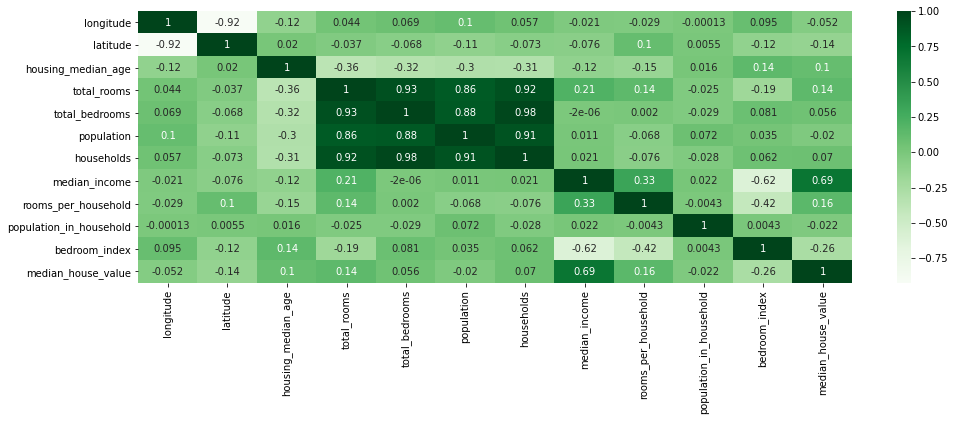

In [23]:
assembler_corr = VectorAssembler(
    inputCols=numerical_cols+ [target],
    outputCol="corr_features",
    handleInvalid="skip")

df_vector = (
    assembler_corr
    .transform(train_data.select(numerical_cols + [target]))
    .select("corr_features")
)
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(
    data=corr_matrix,
    columns = numerical_cols + [target],
    index=numerical_cols+ [target]) 

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,
            cmap="Greens", annot=True);

__Промежуточный вывод__:
- заметная взаимосвязь таргета с признакoм median_income,
- слабая взаимосвязь таргета с признаками latitude, housing_median_age, total_rooms, rooms_per_household, bedroom_index,
- корреляция таргета с остальными признаками очень мала,
- наблюдается весьма высокая взаимосвязь между признаками total_rooms, total_bedrooms, households, а также между population и households.

Эту информацию можно будет учесть в случае необходимости улучшения модели.

## Обучение моделей

In [24]:
def get_metrics(model, data_test):
    """
    Функция для вывода на экран метрик модели RMSE, R2, MAE.
    
    Params:
    model - обученная модель
    data_test - тестовая выборка
    
    Returns:
    rmse, r2, mae - значения метрик на тестовой выборке
    """
    
    predictions = model.transform(data_test)
    
    evaluator = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='rmse')
    rmse = evaluator.evaluate(predictions)

    evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='r2')
    r2 = evaluator_r2.evaluate(predictions)
    
    evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol='prediction', metricName='mae')
    mae = evaluator_mae.evaluate(predictions)

    return rmse, r2, mae

Обучим модель линейной регрессии на всех признаках и посмотрим на значение метрик на тестовом датасете. При обучении будем использовать кросс-валидацию с метрикой RMSE. 

In [25]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr_all_features.regParam, [0.1, 0.01]) \
    .addGrid(lr_all_features.fitIntercept, [False, True])\
    .addGrid(lr_all_features.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=pipeline_all_features,
                          estimatorParamMaps=paramGrid,
                          evaluator= RegressionEvaluator(metricName='rmse', labelCol=target),
                          numFolds=5,
                          seed=RANDOM_SEED
                         )  
model_all_features = crossval.fit(train_data)


# Извлекаем лучшую модель
best_model_all_features = model_all_features.bestModel

# Извлекаем параметры лучшей модели
best_model_params = best_model_all_features.stages[-1].extractParamMap()

# Вывод параметров лучшей модели
print("Параметры лучшей модели:")
for param, value in best_model_params.items():
    print(param.name, ":", value)

rmse_all, r2_all, mae_all = get_metrics(best_model_all_features, test_data)

25/08/16 21:34:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/08/16 21:34:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Параметры лучшей модели:
aggregationDepth : 2
elasticNetParam : 0.5
epsilon : 1.35
featuresCol : features
fitIntercept : True
labelCol : median_house_value
loss : squaredError
maxIter : 100
predictionCol : prediction
regParam : 0.01
solver : auto
standardization : True
tol : 1e-06


Обучим модель линейной регрессии только на числовых признаках.

In [26]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr_num_features.regParam, [0.1, 0.01]) \
    .addGrid(lr_num_features.fitIntercept, [False, True])\
    .addGrid(lr_num_features.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=pipeline_num_features,
                          estimatorParamMaps=paramGrid,
                          evaluator= RegressionEvaluator(metricName='rmse', labelCol=target),
                          numFolds=5,
                          seed=RANDOM_SEED
                         )  
model_num_features = crossval.fit(train_data)

# Извлекаем лучшую модель
best_model_num_features = model_num_features.bestModel

# Извлекаем параметры лучшей модели
best_model_params = best_model_num_features.stages[-1].extractParamMap()

# Вывод параметров лучшей модели
print("Параметры лучшей модели:")
for param, value in best_model_params.items():
    print(param.name, ":", value)
    
rmse_num, r2_num, mae_num = get_metrics(best_model_num_features, test_data)

Параметры лучшей модели:
aggregationDepth : 2
elasticNetParam : 0.5
epsilon : 1.35
featuresCol : scaled_numerical_features
fitIntercept : True
labelCol : median_house_value
loss : squaredError
maxIter : 100
predictionCol : prediction
regParam : 0.1
solver : auto
standardization : True
tol : 1e-06


__Промежуточный вывод__:
- выбрали лучшие модели линейной регрессии (со всеми признаками и только с численными признаками) с помощью кросс-валидации,
- получили параметры лучших моделей и значения метрик на тестовой выборке.

## Анализ результатов

In [27]:
rezults = pd.DataFrame(columns = ['model', 'RMSE', 'R2', 'MAE']) 
rezults.loc[0] = ['all_features', rmse_all, r2_all, mae_all]
rezults.loc[1] = ['numerical_features', rmse_num, r2_num, mae_num]
rezults

,model,RMSE,R2,MAE
0,all_features,67606.775675,0.662404,49028.189942
1,numerical_features,68094.735777,0.657513,49677.137033


Метрики RMSE и MAE ниже, а R2 ближе к 1 у модели, обученной на всех признаках. 
Лучшей оказалась модель линейной регрессии с гиперпараметрами: 
- regParam : 0.01
- fitIntercept : True
- elasticNetParam : 0.5

Попробуем улучшить модель, учитывая корреляцию между признаками. Не будем использовать total_bedrooms, households, population.

In [28]:
numerical_cols = ['longitude', 'latitude', 'housing_median_age',
                  'total_rooms', 'median_income', 'rooms_per_household',
                  'population_in_household', 'bedroom_index']

In [29]:
imputer_new = Imputer(inputCols=numerical_cols, outputCols=numerical_cols, strategy='median')
assembler_new = VectorAssembler(inputCols=numerical_cols,
                                outputCol='numerical_features')
scaler_new = StandardScaler(inputCol='numerical_features',
                            outputCol='scaled_numerical_features')
stages_new = [imputer_new, indexer, encoder, categorical_assembler,
              assembler_new, scaler_new, final_assembler]
lr_new = LinearRegression(labelCol=target, featuresCol='features', regParam=0.1)
pipeline_new = Pipeline(stages=stages_new + [lr_new]) 

paramGrid = ParamGridBuilder()\
    .addGrid(lr_new.regParam, [0.1, 0.01]) \
    .addGrid(lr_new.fitIntercept, [False, True])\
    .addGrid(lr_new.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

crossval = CrossValidator(estimator=pipeline_new,
                          estimatorParamMaps=paramGrid,
                          evaluator= RegressionEvaluator(metricName='rmse', labelCol=target),
                          numFolds=5,
                          seed=RANDOM_SEED)  
model_new = crossval.fit(train_data)

# Извлекаем лучшую модель
best_model_new = model_new.bestModel

# Извлекаем параметры лучшей модели
best_model_params = best_model_new.stages[-1].extractParamMap()

# Вывод наилучших параметров модели
print("Best model parameters:")
for param, value in best_model_params.items():
    print(param.name, ":", value)

rmse_new, r2_new, mae_new = get_metrics(best_model_new, test_data)
print(f'\nRMSE {rmse_new}\nR2 {r2_new} \nMAE {mae_new}')

Best model parameters:
aggregationDepth : 2
elasticNetParam : 1.0
epsilon : 1.35
featuresCol : features
fitIntercept : True
labelCol : median_house_value
loss : squaredError
maxIter : 100
predictionCol : prediction
regParam : 0.1
solver : auto
standardization : True
tol : 1e-06

RMSE 70637.18353323716
R2 0.6314604099797843 
MAE 51526.27040525029


Не удалось улучшить результат. Модель, обученная на всех параметрах, выигрывает.

In [30]:
spark.stop()

__Промежуточный вывод__:

Модель линейной регрессии, обученная на всех входных признаках, показывает лучший результат по метрикам RMSE, R2, MAE.

## Вывод

Мы решали задачу регрессии, обучение с учителем, с использованием фреймворка Spark. Использовали возможности модуля Mllib для подготовки данных, обучения моделей и оценки качества моделей. 

Лучшие метрики показала модель линейной регрессии, обученная на всех признаках, с гиперпараметрами:
- regParam = 0.01,
- fitIntercept = True,
- elasticNetParam = 0.5.

Значение метрик на тестовой выборке:
- RMSE = 67606.78,
- R2 = 0.66,
- MAE = 49028.10. 

Модель делает большие ошибки в оценке стоимости жилья. Удаление мультиколлинеарных признаков не помогло получить модель с лучшими метриками. Модель нуждается в улучшении. Стоит рассмотреть возможность использования другого набора признаков или другого алгоритма обучения, а также возможность обучения на датасете без выбросов.